In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from cycler import cycler

In [18]:
default_cycler = (cycler(color=['#D8153C', '#5B90DC', '#FFAB44', '#0C9FB3', '#57271B',
                                '#3B507D', '#FD6989', '#794D88', '#8A978E', '#3B507D', '#ba2c54']) + 
                  cycler(linestyle=[(0, ()),  # solid
                                    (0, (1, 1)),  # densely dotted
                                    (0, (3, 1, 1, 1)),  # densely dashdotted
                                    (0, (5, 5)),  # dashed
                                    (0, (3, 1, 1, 1, 1, 1)),  # densely dashdotdotted
                                    (0, (5, 1)),  # desnely dashed
                                    (0, (1, 5)),  # dotted
                                    (0, (3, 5, 1, 5)),  # dashdotted
                                    (0, (3, 5, 1, 5, 1, 5)),  # dashdotdotted
                                    (0, ()),  # solid
                                    (0, (1, 1)),  # densely dotted
                                   ]))
plt.rc('axes', prop_cycle = default_cycler)

In [19]:
def getStatEquivLC(time, flux, fluxErr, lag):
    newTime = time - lag
    fluxNew = np.random.normal(flux, fluxErr, len(flux))
    fluxErrNew = fluxErr
    
    fluxNew = np.roll(fluxNew, lag)
    fluxErrNew = np.roll(fluxErrNew, lag)
    newTime = np.roll(newTime, lag)
    
    veritasData = np.c_[newTime, fluxNew, fluxErrNew]
    
    return np.c_[newTime, fluxNew, fluxErrNew]
    

In [20]:
lc1 = np.loadtxt('1ES1011_weekly_veritas.txt', delimiter=',')
lc2 = np.loadtxt('1ES1011_weekly_fermi.txt', delimiter=',')

# lc2 = lc2[(lc2[:, 0] > 56600) & (lc2[:, 0] < 56800)]
# lc2 = getStatEquivLC(lc1[:, 0], lc1[:, 1], lc1[:, 2], -10)
np.savetxt('lc1.txt', lc1, delimiter=',')
np.savetxt('lc2.txt', lc2, delimiter=',')

In [21]:
# subprocess.call('./zdcf.out <<< $"2\n./test\nn\n0\nn\n100\n1ES1011_nightly_veritas.txt\n1ES1011_weekly_fermi.txt" >& output.log', shell=True)
subprocess.call('./zdcf.out <<< $"2\n./test\nn\n0\nn\n1000\nlc1.txt\nlc2.txt" >& output.log', shell=True)

0

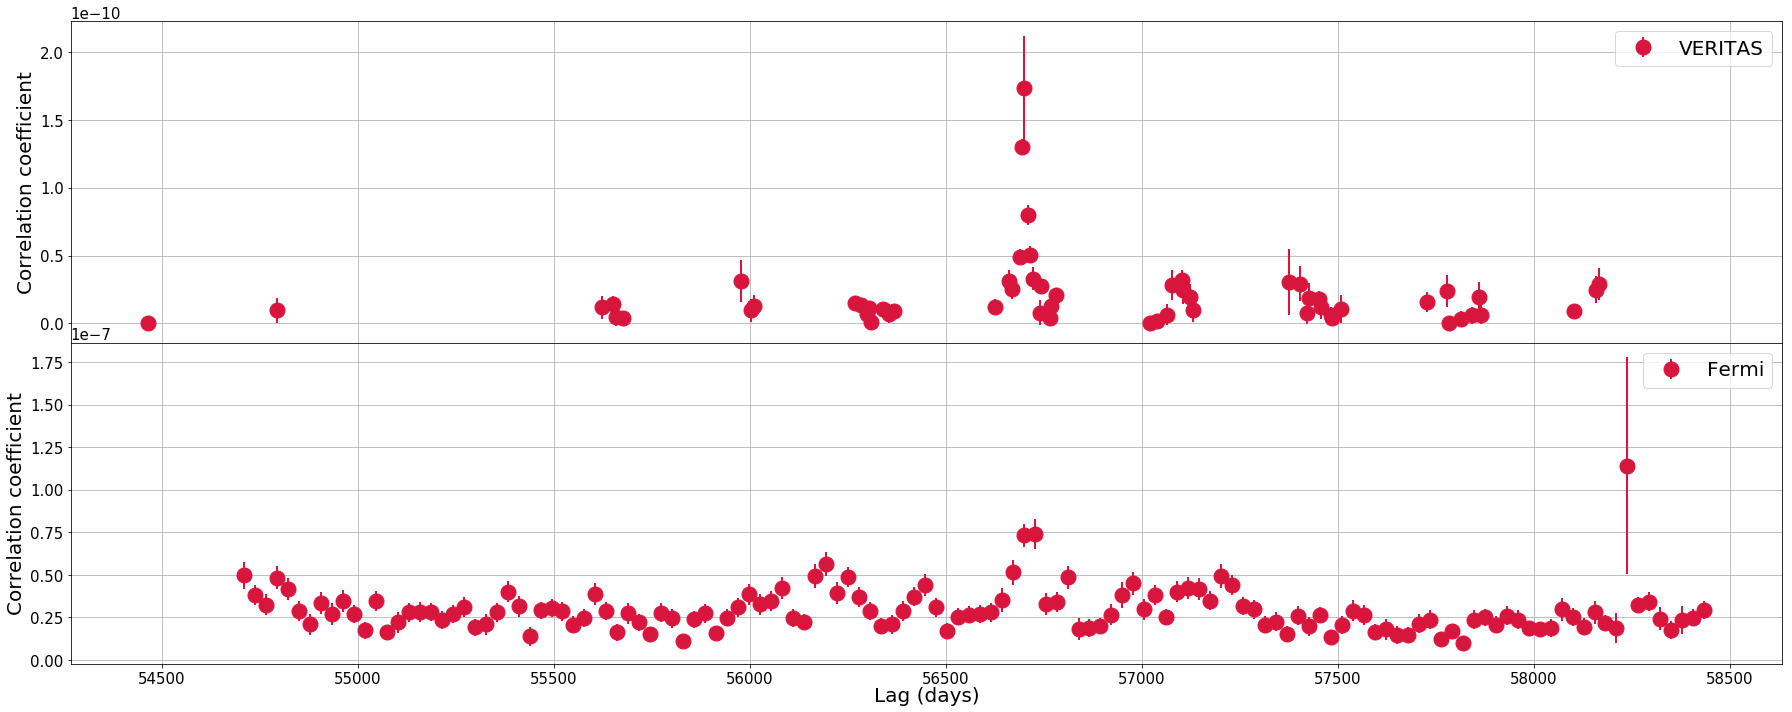

In [42]:
fig = plt.figure(figsize=(25, 10))

ax1 = fig.add_subplot(211)

xTitle = 'MJD'
yTitle = 'Flux'
plt.errorbar(lc1[:, 0],
             lc1[:, 1],
             yerr=lc1[:, 2],
             fmt='o',
             markersize=15, elinewidth=2,
             label='VERITAS',
             zorder=10)

plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

fig.add_subplot(212, sharex=ax1)

plt.errorbar(lc2[:, 0],
             lc2[:, 1],
             yerr=lc2[:, 2],
             fmt='o',
             markersize=15, elinewidth=2,
             label='Fermi',
             zorder=10)

plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

fig.subplots_adjust(hspace=0)

plt.show()


In [23]:
subprocess.call('./plike.out <<< $"test.dcf\n-200\n200" >& plike.log', shell=True)

0

In [33]:
plikeFile = open('plike.log', 'r')

for line in plikeFile:
    if '1 sigma ML interval' in line:
        lag = float(line.split()[5])
    if '= (' in line:
        lagDn = float(line.split()[2])
        lagUp = float(line.split()[4])
print(lagDn, lagUp)

-4.92 43.1


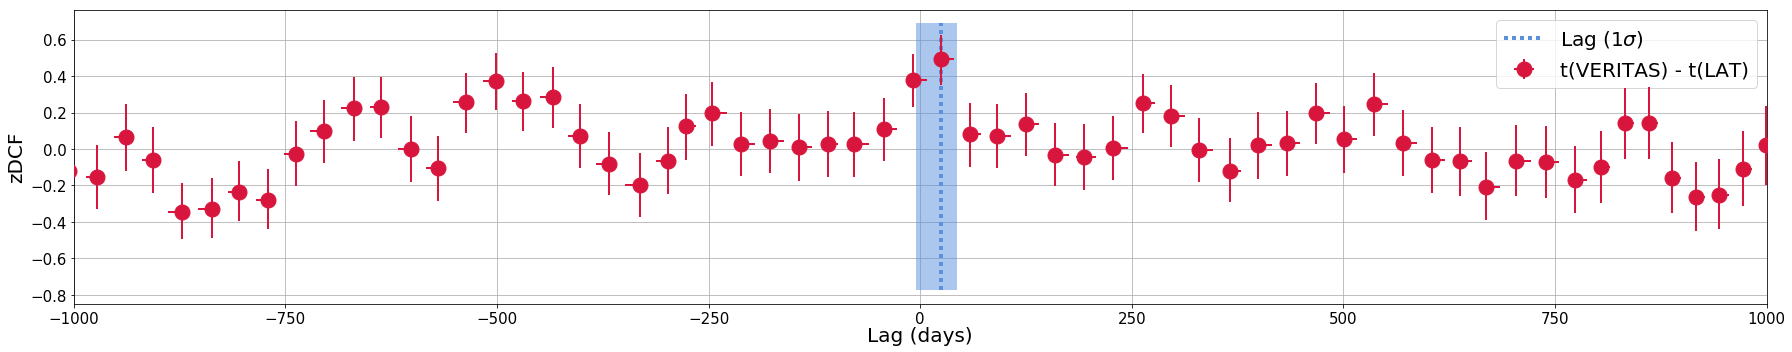

In [49]:
fig = plt.figure(figsize=(25, 5))

zdcf = np.loadtxt('test.dcf')

xTitle = 'Lag (days)'
yTitle = 'zDCF'

plt.errorbar(zdcf[:, 0],
             zdcf[:, 3],
             xerr=[zdcf[:, 1], zdcf[:, 2]],
             yerr=[zdcf[:, 4], zdcf[:, 5]],
             fmt='o',
             markersize=15, elinewidth=2,
             label='t(VERITAS) - t(LAT)',
             zorder=10)


plt.gca().set_xlim([-1000, 1000])
ymin, ymax = plt.gca().get_ylim()
plt.plot([lag, lag], [ymin, ymax], label=r'Lag (1$\sigma$)', lw=4)
plt.fill_between([lagDn, lagUp], ymin, ymax, facecolor='#5B90DC', alpha=0.5)
plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

plt.show()

In [132]:
from scipy.signal import periodogram
from scipy.optimize import curve_fit
from scipy import stats

def psd(x, *p):
    norm, beta = p
    return norm/np.power(x, beta)

In [133]:
sInDay = 60*60*24

8.149269433377407e-21 0.7432531951165934


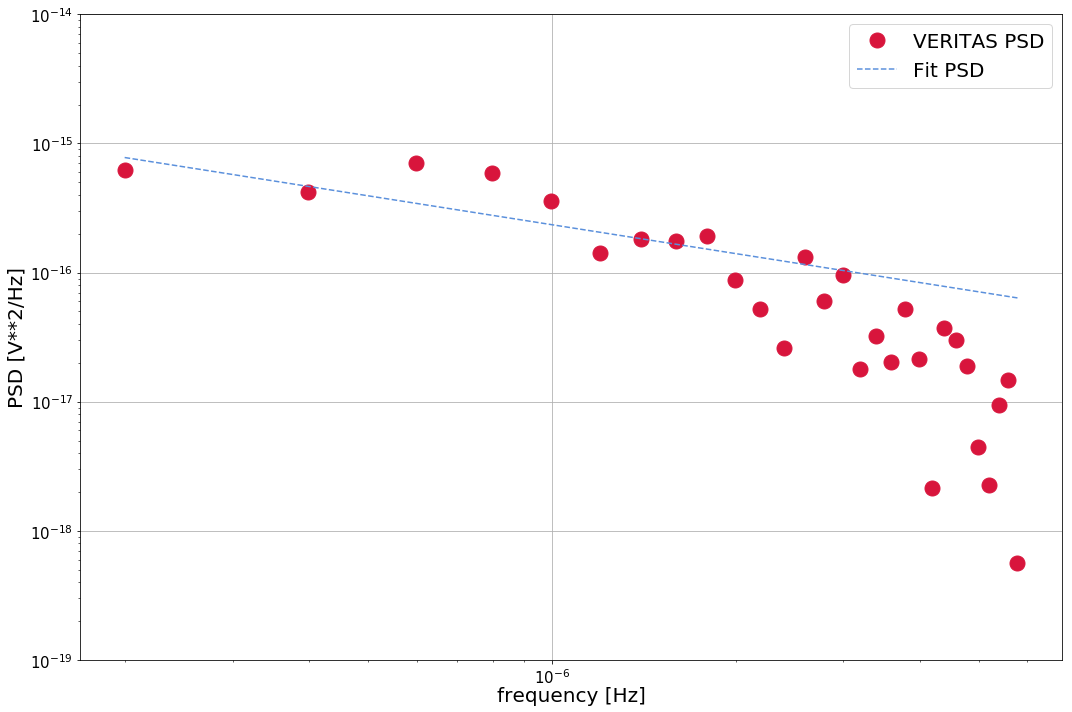

In [142]:
f, Pxx_den = periodogram(lc1[:, 1], 1/(sInDay))

fFit = f[f > 0]
Pxx_denFit = Pxx_den[f > 0]

coeff, var_matrix = curve_fit(psd, fFit, Pxx_denFit, p0=[1e-16, 2])
print(*coeff)
# Get the fitted curve
fit = psd(fFit, *coeff)

fig = plt.figure(figsize=(15, 10))

xTitle = 'frequency [Hz]'
yTitle = 'PSD [V**2/Hz]'

plt.plot(f, Pxx_den, 'o',
         markersize=15,
         label='VERITAS PSD',
         zorder=10)
plt.plot(fFit, fit, '--',
         markersize=15,
         label='Fit PSD',
         zorder=10)
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')

plt.gca().set_ylim([1e-19, 1e-14])
plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

plt.show()

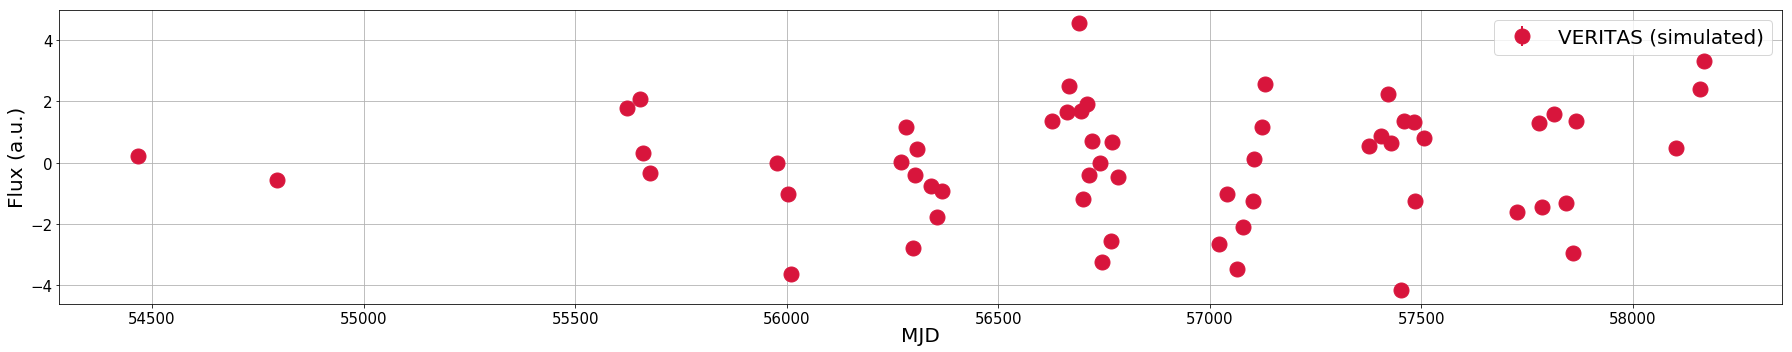

In [171]:
random_state = np.random.RandomState(5)
simVeritas = generate_power_law(len(lc1[:, 1]), sInDay, coeff[1], random_state=random_state)

fig = plt.figure(figsize=(25, 5))
xTitle = 'MJD'
yTitle = 'Flux (a.u.)'
plt.errorbar(lc1[:, 0],
             simVeritas,
             yerr=lc1[:, 2],
             fmt='o',
             markersize=15, elinewidth=2,
             label='VERITAS (simulated)',
             zorder=10)

plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

fig.subplots_adjust(hspace=0)

plt.show()

1.0718352949857171e-13 0.49481296154478455


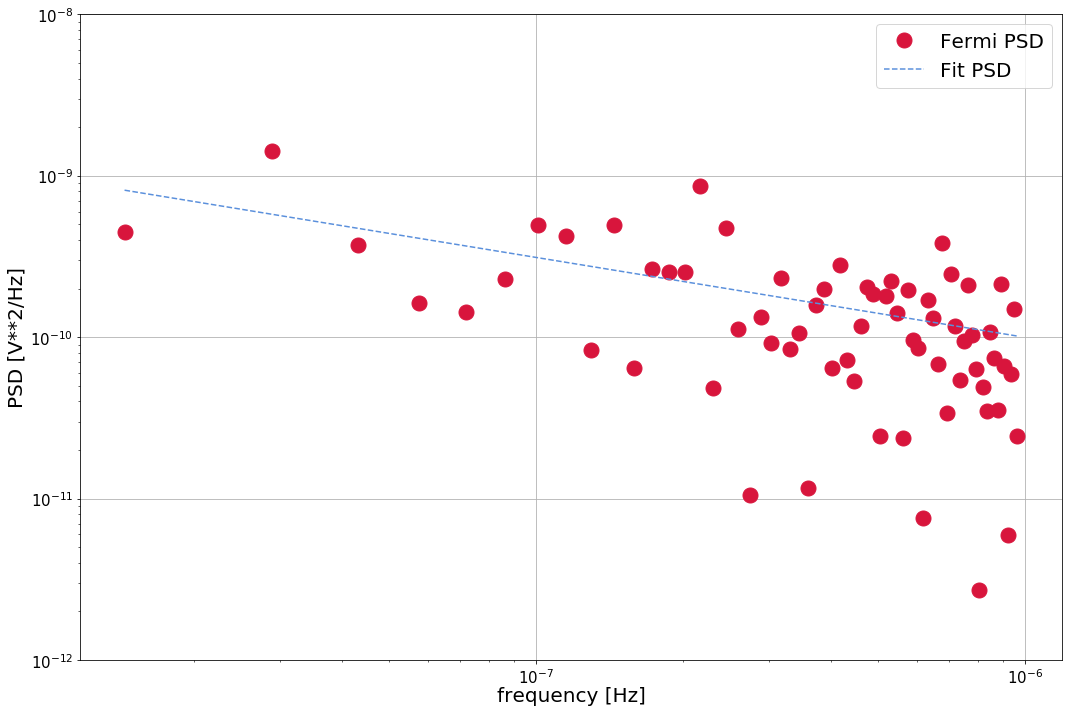

In [157]:
f, Pxx_den = periodogram(lc2[:, 1], 1/(6*sInDay))

fFit = f[f > 0]
Pxx_denFit = Pxx_den[f > 0]

coeff, var_matrix = curve_fit(psd, fFit, Pxx_denFit, p0=[1e-9, 2])
print(*coeff)
# Get the fitted curve
fit = psd(fFit, *coeff)


fig = plt.figure(figsize=(15, 10))

xTitle = 'frequency [Hz]'
yTitle = 'PSD [V**2/Hz]'

plt.plot(f, Pxx_den, 'o',
         markersize=15,
         label='Fermi PSD',
         zorder=10)
plt.plot(fFit, fit, '--',
         markersize=15,
         label='Fit PSD',
         zorder=10)
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')

plt.gca().set_ylim([1e-12, 1e-8])
plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

plt.show()


In [158]:
from astroML.fourier import PSD_continuous
from astroML.time_series import generate_power_law

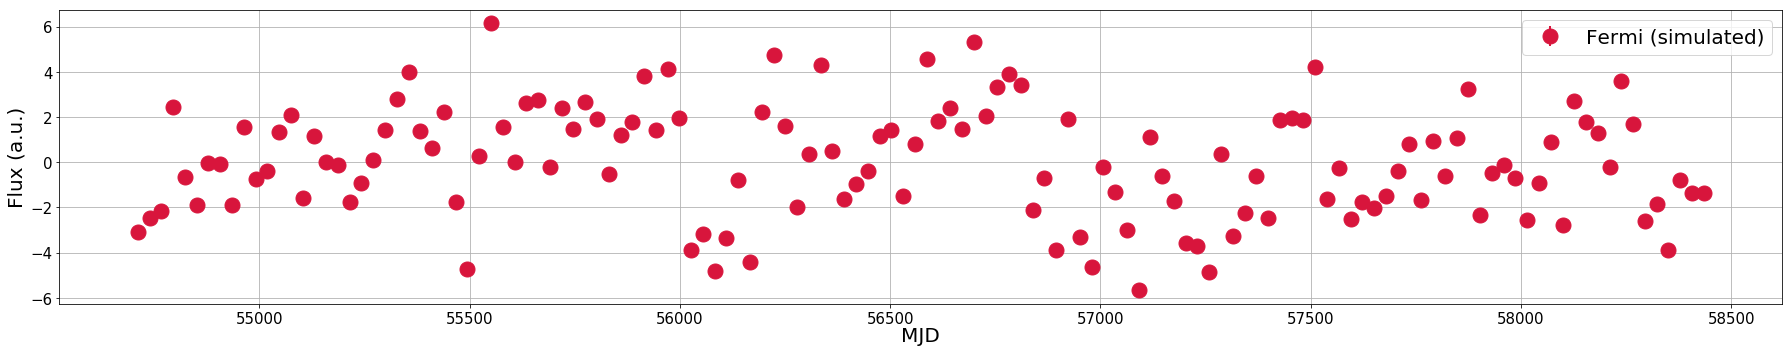

In [159]:
random_state = np.random.RandomState(2)
simFermi = generate_power_law(len(lc2[:, 1]), (6*sInDay), coeff[1], random_state=random_state)

fig = plt.figure(figsize=(25, 5))
xTitle = 'MJD'
yTitle = 'Flux (a.u.)'
plt.errorbar(lc2[:, 0],
             simFermi,
             yerr=lc2[:, 2],
             fmt='o',
             markersize=15, elinewidth=2,
             label='Fermi (simulated)',
             zorder=10)

plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

fig.subplots_adjust(hspace=0)

plt.show()

In [161]:
np.savetxt('simLc1.txt', np.c_[lc1[:, 0], simVeritas, lc1[:, 2]], delimiter=',')
np.savetxt('simLc2.txt', np.c_[lc2[:, 0], simFermi, lc2[:, 2]], delimiter=',')
subprocess.call('./zdcf.out <<< $"2\n./sim\nn\n0\nn\n1000\nsimLc1.txt\nsimLc2.txt" >& simOutput.log', shell=True)
subprocess.call('./plike.out <<< $"sim.dcf\n-200\n200" >& simPlike.log', shell=True)

simPlikeFile = open('simPlike.log', 'r')

for line in simPlikeFile:
    if '1 sigma ML interval' in line:
        lag = float(line.split()[5])
    if '= (' in line:
        lagDn = float(line.split()[2])
        lagUp = float(line.split()[4])

In [162]:
fig = plt.figure(figsize=(25, 5))

simZdcf = np.loadtxt('sim.dcf')

xTitle = 'Lag (days)'
yTitle = 'zDCF'

plt.errorbar(simZdcf[:, 0],
             simZdcf[:, 3],
             xerr=[simZdcf[:, 1], simZdcf[:, 2]],
             yerr=[simZdcf[:, 4], simZdcf[:, 5]],
             fmt='o',
             markersize=15, elinewidth=2,
             label='t(VERITAS) - t(LAT) (simulated)',
             zorder=10)


plt.gca().set_xlim([-1000, 1000])
ymin, ymax = plt.gca().get_ylim()
plt.plot([lag, lag], [ymin, ymax], label=r'Lag (1$\sigma$)', lw=4)
plt.fill_between([lagDn, lagUp], ymin, ymax, facecolor='#5B90DC', alpha=0.5)
plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()

plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-162-34a9d8179733>", line 3, in <module>
    simZdcf = np.loadtxt('sim.dcf')
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/site-packages/numpy/lib/npyio.py", line 917, in loadtxt
    fh = np.lib._datasource.open(fname, 'rt', encoding=encoding)
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/site-packages/numpy/lib/_datasource.py", line 259, in open
    ds = DataSource(destpath)
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/site-packages/numpy/lib/_datasource.py", line 315, in __init__
    self._destpath = os.path.abspath(destpath)
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/posixpath.py", line 383, in abspath
    cwd = os.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, a

FileNotFoundError: [Errno 2] No such file or directory

In [172]:
s = np.random.normal(mu, sigma, 1000)
s

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-172-42b5bde46e4c>", line 1, in <module>
    s = np.random.normal(mu, sigma, 1000)
NameError: name 'mu' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1806, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ogueta/work/sw/anaconda/lib/python3.6/site-packages/IPython/core/ultratb.py", line 1090, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)

NameError: name 'mu' is not defined

In [8]:
s = np.round(np.random.normal(0, 10, 1)[0])
s

-18.0

In [12]:
from scipy.stats import norm

In [25]:
vals = norm.ppf([0.003, 0.05, 0.317310507863, 0.682689492137, 0.95, 0.997])
vals

array([-2.74778139, -1.64485363, -0.47523285,  0.47523285,  1.64485363,
        2.74778139])

In [23]:
0.47523285 +  0.47523285

0.9504657

In [19]:
1.64485363 + 1.64485363

3.28970726

In [20]:
print(norm.stats(moments='mv'))

(array(0.), array(1.))


In [26]:
norm.cdf(vals)

array([0.003     , 0.05      , 0.31731051, 0.68268949, 0.95      ,
       0.997     ])

In [27]:
0.317310507863/2

0.1586552539315

In [28]:
vals = norm.ppf([0.1586552539315, 0.682689492137 + 0.1586552539315])
vals

array([-1.,  1.])

In [112]:
power = np.load('power.npy')
freq = np.load('freq.npy')

In [104]:
from scipy.optimize import curve_fit

In [105]:
def psd(x, *p):
    norm, beta = p
    return norm/np.power(x, beta)

In [132]:
print(np.max(power))

pars, varMatrix = curve_fit(psd, freq, power, p0=[np.max(power), 0.5], maxfev = 5000)
print(pars)

3.1972768658156563e-16
[1.76816503e-24 1.13057431e+00]


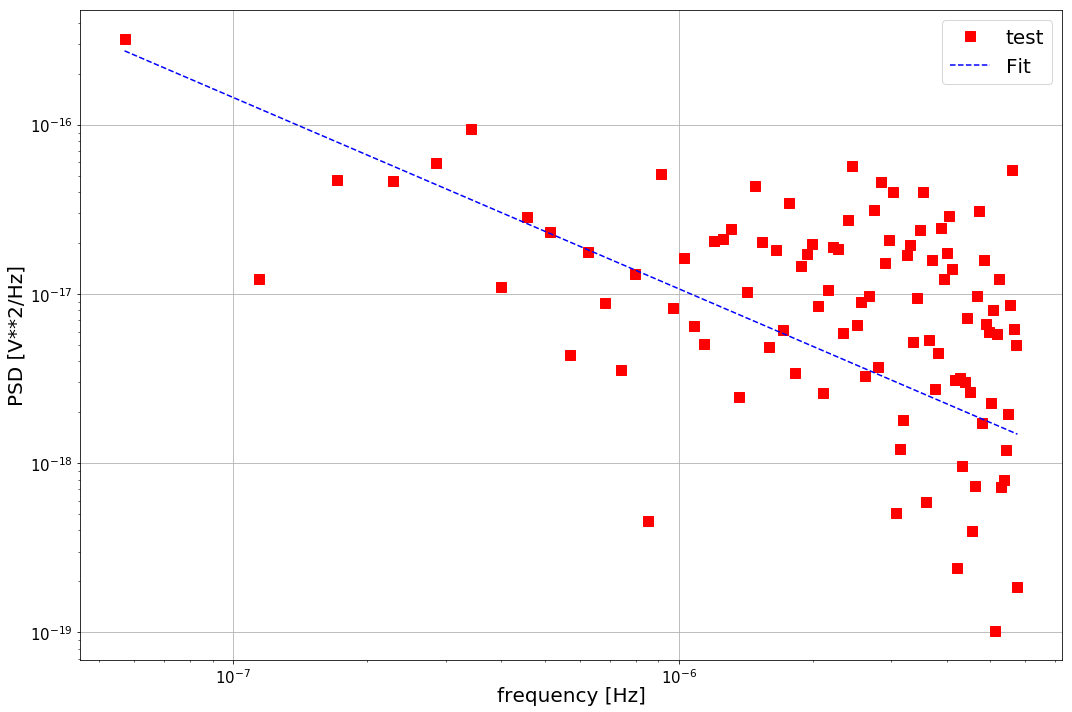

In [133]:
fig = plt.figure(figsize=(15, 10))

xTitle = 'frequency [Hz]'
yTitle = 'PSD [V**2/Hz]'

plt.plot(freq, power, 's',
         color='r',
         markersize=10,
         label='test',
         zorder=10)
testPars = pars
# testPars[0] = 1e-20
# testPars[1] = 0.4
plt.plot(freq, psd(freq, *testPars), '--',
         color='b',
         label='Fit',
         zorder=10)
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')

plt.xlabel(xTitle, fontsize=20, labelpad=0)
plt.ylabel(yTitle, fontsize=20)
plt.gca().get_yaxis().get_offset_text().set_fontsize(15)

plt.legend(loc='upper right', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.tight_layout()
plt.show()

In [113]:
np.max(power)/ np.mean(power)

17.755921948266277

In [93]:
v = [4.457411026055384e-16, 3.8627484364062303e-17, 1.276453621203727e-16, 3.207945125812089e-16, 1.068897951218716e-16, 4.528426822217043e-17, 9.335706354984415e-17, 1.203406391033435e-16, 2.0535521931165947e-16, 9.594399823153013e-17, 1.5633872862124784e-17, 2.2042053795614654e-18, 8.755839155933434e-17, 6.250027258111565e-18, 5.5154910968673145e-18, 7.53926822535044e-17, 2.7653482186370676e-17, 2.2374194881225068e-18, 3.4327522532905746e-17, 8.818105584768554e-18, 4.450655923431323e-17, 3.210791376048618e-17, 1.2290234230200237e-17, 4.1747432166439726e-18, 1.095230235273197e-17, 6.439085361601535e-18, 4.5426568870308167e-17, 1.5252973196361765e-17, 2.2595998254319105e-17, 2.915082218638361e-18, 2.2151077312585468e-17, 2.0822600373707472e-16, 1.2842493233515265e-16, 8.854544715076969e-17, 9.213662826523771e-18, 4.9028391356731215e-17, 3.4032131274984667e-17, 2.4206620111617743e-17, 4.301451346355082e-17, 3.108613169060545e-17, 1.1422098925748598e-16, 9.644839619193939e-17]

In [94]:
np.max(v)/ np.mean(v)

6.4315414224439795

In [134]:
6.366881433316762e-08/1.14170546e-07

0.5576640960722709

In [135]:
import time

In [137]:
time.clock?

In [154]:
np.exp(-0.5)

0.6065306597126334

In [141]:
-0.5 - (-0.5)

0.0

In [143]:
a = 3*0.36
a

1.08

In [144]:
b = a + 2.9*0.64
b

2.936

In [146]:
1 - 0.64

0.36